## Deliverable 3: Optimize the Model

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint

2022-12-19 16:18:10.497447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.sample(5)

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
26372,760536234,ST LUKES COMMUNITY HEALTH SERVICES,T3,Independent,C1000,Heathcare,Trust,1,50M+,N,261164561,0
12201,432007496,COMMUNITY ANCILLARY SERVICES INC,T3,Independent,C1000,Preservation,Trust,1,50M+,N,29400351,0
19378,474728463,TOPS CLUB INC,T3,CompanySponsored,C1200,Preservation,Association,1,0,N,5000,0
27865,810515202,PRAIRIE RIDGE VILLAGE LLP,T3,Independent,C1000,Preservation,Association,1,1M-5M,N,3631076,1
4007,237529896,GROVER CITY GRANGE 746,T8,Independent,C1000,Preservation,Trust,1,0,N,5000,1


In [3]:
# Check if STATUS has a dominant value (99%)
application_df['STATUS'].value_counts()

1    34294
0        5
Name: STATUS, dtype: int64

In [4]:
# # Check if SPECIAL_CONSIDERATIONS has a dominant value (99%)
application_df['SPECIAL_CONSIDERATIONS'].value_counts()

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

In [5]:
# Check the values of ORGANIZATION for dominance
application_df['ORGANIZATION'].value_counts()

Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: ORGANIZATION, dtype: int64

In [6]:
# Check the values of AFFILIATION for dominance
application_df['AFFILIATION'].value_counts()

Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: AFFILIATION, dtype: int64

In [7]:
# Should INCOME_AMT be binned?
application_df['INCOME_AMT'].value_counts()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

### OPTIMIZATION ATTEMPT 1: 
- **Drop STATUS and SPECIAL_CONSIDERATIONS** (Columns have dominant values that do not provide much insight to model in training)
- **Bin INCOME_AMT**
- **Neurons updated as per number of input features**
- epochs = 100 
- Activation function: relu
- Target: IS_SUCCESSFUL  
- Features: APPLICATION_TYPE, AFFILIATION, CLASSIFICATION, USE_CASE, ORGANIZATION, INCOME_AMT, ASK_AMT
- Hidden layers unchanged (as in Deliverable 2)

In [8]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(['EIN','NAME','STATUS','SPECIAL_CONSIDERATIONS'],axis=1)

In [9]:
# Bucket Application Type
application_count = application_df['APPLICATION_TYPE'].value_counts()

# Determine which values to replace if counts are less than ...?
replace_application = list(application_count[application_count<500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Bucket CLASSIFICATION values
classification_count = application_df.CLASSIFICATION.value_counts()

# Determine which values to replace if counts are less than ...?
replace_class = list(classification_count[classification_count<1800].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")


In [10]:
# Bucketing INCOME_AMT
income_count = application_df['INCOME_AMT'].value_counts()

# Determine which values to replace if counts are less than ...?
replace_income = list(income_count[income_count < 500].index)

# Replace in dataframe
for cls in replace_income:
    application_df.INCOME_AMT = application_df.INCOME_AMT.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.INCOME_AMT.value_counts()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
Other              564
10000-24999        543
Name: INCOME_AMT, dtype: int64

In [11]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes=='object'].index.tolist()
application_df[application_cat].nunique()

APPLICATION_TYPE    9
AFFILIATION         6
CLASSIFICATION      6
USE_CASE            5
ORGANIZATION        4
INCOME_AMT          7
dtype: int64

In [12]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)

# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True,right_index=True)
application_df = application_df.drop(columns=application_cat)

In [13]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values.reshape(-1, 1)
X = application_df.drop("IS_SUCCESSFUL", axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, stratify=y)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
len(X_train_scaled[0])

38

In [15]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

number_input_features = len(X_train_scaled[0]) # 38
# Neurons for Hidden layer 1 
hidden_nodes_layer1 = 70      # <76 (=38*2)
# Neurons for Hidden layer 2
hidden_nodes_layer2 = 70

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,input_dim=number_input_features,activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2730      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 7,771
Trainable params: 7,771
Non-trainable params: 0
_________________________________________________________________


2022-12-19 16:19:08.284040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# Compile the model
nn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 1s 979us/step - loss: 0.5715 - accuracy: 0.7193
Epoch 2/100
804/804 [==============================] - 1s 961us/step - loss: 0.5560 - accuracy: 0.7271
Epoch 3/100
804/804 [==============================] - 1s 979us/step - loss: 0.5533 - accuracy: 0.7282
Epoch 4/100
804/804 [==============================] - 1s 964us/step - loss: 0.5512 - accuracy: 0.7291
Epoch 5/100
804/804 [==============================] - 1s 962us/step - loss: 0.5510 - accuracy: 0.7301
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5503 - accuracy: 0.7301
Epoch 7/100
804/804 [==============================] - 1s 944us/step - loss: 0.5485 - accuracy: 0.7321
Epoch 8/100
804/804 [==============================] - 1s 950us/step - loss: 0.5476 - accuracy: 0.7321
Epoch 9/100
804/804 [==============================] - 1s 972us/step - loss: 0.5473 - accuracy: 0.7317
Epoch 10/100
804/804 [==============================] - 1s 991us/step - los

804/804 [==============================] - 1s 979us/step - loss: 0.5365 - accuracy: 0.7383
Epoch 81/100
804/804 [==============================] - 1s 931us/step - loss: 0.5367 - accuracy: 0.7386
Epoch 82/100
804/804 [==============================] - 1s 980us/step - loss: 0.5365 - accuracy: 0.7391
Epoch 83/100
804/804 [==============================] - 1s 919us/step - loss: 0.5364 - accuracy: 0.7388
Epoch 84/100
804/804 [==============================] - 1s 934us/step - loss: 0.5365 - accuracy: 0.7384
Epoch 85/100
804/804 [==============================] - 1s 953us/step - loss: 0.5364 - accuracy: 0.7383
Epoch 86/100
804/804 [==============================] - 1s 913us/step - loss: 0.5360 - accuracy: 0.7386
Epoch 87/100
804/804 [==============================] - 1s 903us/step - loss: 0.5362 - accuracy: 0.7387
Epoch 88/100
804/804 [==============================] - 1s 932us/step - loss: 0.5363 - accuracy: 0.7385
Epoch 89/100
804/804 [==============================] - 1s 900us/step - loss:

In [17]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5572 - accuracy: 0.7311 - 305ms/epoch - 1ms/step
Loss: 0.5571541786193848, Accuracy: 0.7310787439346313


### OPTIMIZATION ATTEMPT 2: 
- **More neurons added** to hidden layers
- **Drop STATUS and SPECIAL_CONSIDERATIONS** (Columns have dominant values that do not provide much insight to model in training)
- **Bin INCOME_AMT**
- epochs = 100
- Activation function: relu
- Target: IS_SUCCESSFUL  
- Features: APPLICATION_TYPE, AFFILIATION, CLASSIFICATION, USE_CASE, ORGANIZATION, INCOME_AMT, ASK_AMT
- Hidden layers unchanged

In [18]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

# same input features as above model
# Neurons for Hidden layer 1 
neuron_layer1 = 70
# Neurons for Hidden layer 2
neuron_layer2 = 140

nn_inc_neuron = tf.keras.models.Sequential()

# First hidden layer
nn_inc_neuron.add(tf.keras.layers.Dense(units=neuron_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_inc_neuron.add(tf.keras.layers.Dense(units=neuron_layer2, activation="relu"))

# Output layer
nn_inc_neuron.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_inc_neuron.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 70)                2730      
                                                                 
 dense_4 (Dense)             (None, 140)               9940      
                                                                 
 dense_5 (Dense)             (None, 1)                 141       
                                                                 
Total params: 12,811
Trainable params: 12,811
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compile the model
nn_inc_neuron.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#  number of epochs = 100
fit_model_inc_neuron = nn_inc_neuron.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5715 - accuracy: 0.7183
Epoch 2/100
804/804 [==============================] - 1s 999us/step - loss: 0.5561 - accuracy: 0.7274
Epoch 3/100
804/804 [==============================] - 1s 999us/step - loss: 0.5533 - accuracy: 0.7276
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5510 - accuracy: 0.7296
Epoch 5/100
804/804 [==============================] - 1s 998us/step - loss: 0.5495 - accuracy: 0.7297
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5490 - accuracy: 0.7306
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5483 - accuracy: 0.7319
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5474 - accuracy: 0.7323
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5466 - accuracy: 0.7336
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5465 - 

804/804 [==============================] - 1s 938us/step - loss: 0.5356 - accuracy: 0.7377
Epoch 81/100
804/804 [==============================] - 1s 953us/step - loss: 0.5356 - accuracy: 0.7383
Epoch 82/100
804/804 [==============================] - 1s 940us/step - loss: 0.5356 - accuracy: 0.7385
Epoch 83/100
804/804 [==============================] - 1s 936us/step - loss: 0.5347 - accuracy: 0.7386
Epoch 84/100
804/804 [==============================] - 1s 931us/step - loss: 0.5350 - accuracy: 0.7392
Epoch 85/100
804/804 [==============================] - 1s 934us/step - loss: 0.5354 - accuracy: 0.7385
Epoch 86/100
804/804 [==============================] - 1s 935us/step - loss: 0.5348 - accuracy: 0.7387
Epoch 87/100
804/804 [==============================] - 1s 933us/step - loss: 0.5356 - accuracy: 0.7393
Epoch 88/100
804/804 [==============================] - 1s 930us/step - loss: 0.5351 - accuracy: 0.7382
Epoch 89/100
804/804 [==============================] - 1s 936us/step - loss:

In [23]:
# Evaluate the model using the test data
model_loss1, model_accuracy1 = nn_inc_neuron.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss1}, Accuracy: {model_accuracy1}")

268/268 - 0s - loss: 0.5570 - accuracy: 0.7315 - 215ms/epoch - 803us/step
Loss: 0.5570030808448792, Accuracy: 0.7315452098846436


### OPTIMIZATION ATTEMPT 3: 
- **More hidden layers added**
- **Drop STATUS and SPECIAL_CONSIDERATIONS** (Columns have dominant values that do not provide much insight to model in training)
- **Bin INCOME_AMT**
- epochs = 100
- Activation function: relu
- Target: IS_SUCCESSFUL  
- Features: APPLICATION_TYPE, AFFILIATION, CLASSIFICATION, USE_CASE, ORGANIZATION, INCOME_AMT, ASK_AMT

In [24]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

# same input features as above model
# Neurons for Hidden layer 1 
hid_layer1 = 70
# Neurons for Hidden layer 2
hid_layer2 = 100
# Neurons for Hidden layer 3
hid_layer3 = 120

nn_inc_layer = tf.keras.models.Sequential()

# First hidden layer
nn_inc_layer.add(tf.keras.layers.Dense(units=hid_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_inc_layer.add(tf.keras.layers.Dense(units=hid_layer2, activation="relu"))

# Third hidden layer
nn_inc_layer.add(tf.keras.layers.Dense(units=hid_layer3, activation="relu"))

# Output layer
nn_inc_layer.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_inc_layer.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 70)                2730      
                                                                 
 dense_11 (Dense)            (None, 100)               7100      
                                                                 
 dense_12 (Dense)            (None, 120)               12120     
                                                                 
 dense_13 (Dense)            (None, 1)                 121       
                                                                 
Total params: 22,071
Trainable params: 22,071
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compile the model
nn_inc_layer.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#  number of epochs = 100
fit_model_inc_layer = nn_inc_layer.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.5703 - accuracy: 0.7209
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5560 - accuracy: 0.7281
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5532 - accuracy: 0.7299
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5513 - accuracy: 0.7310
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5504 - accuracy: 0.7315
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5486 - accuracy: 0.7315
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5484 - accuracy: 0.7328
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5471 - accuracy: 0.7338
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5469 - accuracy: 0.7343
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5462 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.5343 - accuracy: 0.7395
Epoch 82/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5347 - accuracy: 0.7390
Epoch 83/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5338 - accuracy: 0.7397
Epoch 84/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5348 - accuracy: 0.7393
Epoch 85/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5336 - accuracy: 0.7395
Epoch 86/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7393
Epoch 87/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7387
Epoch 88/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5338 - accuracy: 0.7399
Epoch 89/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5336 - accuracy: 0.7390
Epoch 90/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5338 - accuracy: 

In [26]:
# Evaluate the model using the test data
model_loss2, model_accuracy2 = nn_inc_layer.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss2}, Accuracy: {model_accuracy2}")

268/268 - 0s - loss: 0.5697 - accuracy: 0.7329 - 294ms/epoch - 1ms/step
Loss: 0.5697104930877686, Accuracy: 0.7329446077346802


### OPTIMIZATION ATTEMPT 4: 
- **epochs increased to 200**
- **Hidden layers and neurons as above model**
- **Drop STATUS and SPECIAL_CONSIDERATIONS** (Columns have dominant values that do not provide much insight to model in training)
- **Bin INCOME_AMT**
- Activation function: relu
- Target: IS_SUCCESSFUL  
- Features: APPLICATION_TYPE, AFFILIATION, CLASSIFICATION, USE_CASE, ORGANIZATION, INCOME_AMT, ASK_AMT

In [27]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

# same input features as above model
# Neurons for Hidden layer 1 
hidden_layer1 = 70
# Neurons for Hidden layer 2
hidden_layer2 = 100
hidden_layer3 = 120

nn_inc_epochs = tf.keras.models.Sequential()

# First hidden layer
nn_inc_epochs.add(tf.keras.layers.Dense(units=hidden_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn_inc_epochs.add(tf.keras.layers.Dense(units=hidden_layer2, activation="relu"))

# Third hidden layer
nn_inc_epochs.add(tf.keras.layers.Dense(units=hidden_layer3, activation="relu"))

# Output layer
nn_inc_epochs.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_inc_epochs.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 70)                2730      
                                                                 
 dense_15 (Dense)            (None, 100)               7100      
                                                                 
 dense_16 (Dense)            (None, 120)               12120     
                                                                 
 dense_17 (Dense)            (None, 1)                 121       
                                                                 
Total params: 22,071
Trainable params: 22,071
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile the model
nn_inc_epochs.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Increase the number of epochs to 200
fit_model_inc_epochs = nn_inc_epochs.fit(X_train_scaled, y_train, epochs=200)

Epoch 1/200
804/804 [==============================] - 2s 1ms/step - loss: 0.5686 - accuracy: 0.7229
Epoch 2/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5554 - accuracy: 0.7283
Epoch 3/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5522 - accuracy: 0.7302
Epoch 4/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5507 - accuracy: 0.7309
Epoch 5/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5498 - accuracy: 0.7311
Epoch 6/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5484 - accuracy: 0.7311
Epoch 7/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5476 - accuracy: 0.7344
Epoch 8/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5473 - accuracy: 0.7336
Epoch 9/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5464 - accuracy: 0.7331
Epoch 10/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5457 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.5340 - accuracy: 0.7392
Epoch 82/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5346 - accuracy: 0.7392
Epoch 83/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5335 - accuracy: 0.7384
Epoch 84/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5339 - accuracy: 0.7399
Epoch 85/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5344 - accuracy: 0.7388
Epoch 86/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5341 - accuracy: 0.7388
Epoch 87/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5339 - accuracy: 0.7394
Epoch 88/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5337 - accuracy: 0.7390
Epoch 89/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5351 - accuracy: 0.7391
Epoch 90/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5339 - accuracy: 

804/804 [==============================] - 1s 1ms/step - loss: 0.5326 - accuracy: 0.7400
Epoch 161/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 0.7396
Epoch 162/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5320 - accuracy: 0.7393
Epoch 163/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5320 - accuracy: 0.7399
Epoch 164/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5324 - accuracy: 0.7402
Epoch 165/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5326 - accuracy: 0.7399
Epoch 166/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5324 - accuracy: 0.7401
Epoch 167/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5325 - accuracy: 0.7399
Epoch 168/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5323 - accuracy: 0.7396
Epoch 169/200
804/804 [==============================] - 1s 1ms/step - loss: 0.5328 - a

In [29]:
# Evaluate the model using the test data
model_loss3, model_accuracy3 = nn_inc_epochs.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss3}, Accuracy: {model_accuracy3}")

268/268 - 0s - loss: 0.5900 - accuracy: 0.7296 - 306ms/epoch - 1ms/step
Loss: 0.5899980664253235, Accuracy: 0.7295626997947693


### OPTIMIZATION ATTEMPT 5: 
- Change Activation Function from relu to tanh
- Hidden layers and neurons as above model
- epochs = 150 
- Target: IS_SUCCESSFUL  
- Features: APPLICATION_TYPE, AFFILIATION, CLASSIFICATION, USE_CASE, ORGANIZATION, INCOME_AMT, ASK_AMT

In [30]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
hidden_nodes1 = 70 
hidden_nodes2 = 100 
hidden_nodes3 = 120                                              

nn_tanh = tf.keras.models.Sequential()

# First hidden layer
nn_tanh.add(tf.keras.layers.Dense(units=hidden_nodes1,input_dim=number_input_features,activation='tanh'))

# Second hidden layer
nn_tanh.add(tf.keras.layers.Dense(units=hidden_nodes2,activation='tanh'))

# Third hidden layer
nn_tanh.add(tf.keras.layers.Dense(units=hidden_nodes3,activation='tanh'))

# Output layer 
nn_tanh.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

# Check the structure of the model
nn_tanh.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 70)                2730      
                                                                 
 dense_19 (Dense)            (None, 100)               7100      
                                                                 
 dense_20 (Dense)            (None, 120)               12120     
                                                                 
 dense_21 (Dense)            (None, 1)                 121       
                                                                 
Total params: 22,071
Trainable params: 22,071
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Compile the model
nn_tanh.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train the model with 150 epochs
fit_model_tanh = nn_tanh.fit(X_train_scaled, y_train, epochs=150)

Epoch 1/150
804/804 [==============================] - 2s 1ms/step - loss: 0.5767 - accuracy: 0.7175
Epoch 2/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5616 - accuracy: 0.7278
Epoch 3/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5576 - accuracy: 0.7284
Epoch 4/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5545 - accuracy: 0.7273
Epoch 5/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5521 - accuracy: 0.7297
Epoch 6/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5507 - accuracy: 0.7301
Epoch 7/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5510 - accuracy: 0.7305
Epoch 8/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5493 - accuracy: 0.7307
Epoch 9/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5480 - accuracy: 0.7325
Epoch 10/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5475 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.5347 - accuracy: 0.7393
Epoch 82/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5349 - accuracy: 0.7381
Epoch 83/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5346 - accuracy: 0.7400
Epoch 84/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5347 - accuracy: 0.7386
Epoch 85/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5349 - accuracy: 0.7380
Epoch 86/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5348 - accuracy: 0.7372
Epoch 87/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5345 - accuracy: 0.7385
Epoch 88/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5349 - accuracy: 0.7369
Epoch 89/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5348 - accuracy: 0.7372
Epoch 90/150
804/804 [==============================] - 1s 1ms/step - loss: 0.5343 - accuracy: 

In [32]:
# Evaluate the model using the test data
model_loss4, model_accuracy4 = nn_tanh.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss4}, Accuracy: {model_accuracy4}")

268/268 - 0s - loss: 0.5576 - accuracy: 0.7306 - 305ms/epoch - 1ms/step
Loss: 0.5576385855674744, Accuracy: 0.7306122183799744


### OPTIMIZATION ATTEMPT 6:
- Relook at features again

In [33]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.sample(5)

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
28774,813460918,ALTRUISM ACROSS BORDERS INC,T3,Independent,C1200,Preservation,Trust,1,0,N,5000,1
10161,331000662,NATIONAL INSTITUTE OF GOVERNMENTAL PURCHASING INC,T3,CompanySponsored,C2800,Preservation,Association,1,0,N,5000,1
6720,270439248,VALLEY HEIGHTS BOOSTER CLUB INC,T3,Independent,C1000,Preservation,Trust,1,0,N,5000,0
30888,900142847,NATIONAL ASSOCIATION OF CORPORATE DIRECTORS,T3,CompanySponsored,C2000,Preservation,Trust,1,100000-499999,N,181360,0
2048,203612046,TOASTMASTERS INTERNATIONAL,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,1


In [34]:
application_df.nunique()

EIN                       34299
NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [35]:
application_df.ASK_AMT.value_counts()

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64

In [36]:
application_df.NAME.value_counts()

PARENT BOOSTER USA INC                                                  1260
TOPS CLUB INC                                                            765
UNITED STATES BOWLING CONGRESS INC                                       700
WASHINGTON STATE UNIVERSITY                                              492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                          408
                                                                        ... 
ST LOUIS SLAM WOMENS FOOTBALL                                              1
AIESEC ALUMNI IBEROAMERICA CORP                                            1
WEALLBLEEDRED ORG INC                                                      1
AMERICAN SOCIETY FOR STANDARDS IN MEDIUMSHIP & PSYCHICAL INVESTIGATI       1
WATERHOUSE CHARITABLE TR                                                   1
Name: NAME, Length: 19568, dtype: int64

In [37]:
application_df.EIN.value_counts()

10520599     1
626274659    1
630475330    1
630416100    1
630357662    1
            ..
383880377    1
383876652    1
383874900    1
383871370    1
996086871    1
Name: EIN, Length: 34299, dtype: int64

- Looks like EIN is a unique identifier.
- Considering to drop EIN (Unique ID for row ~ index), STATUS(has 99% dominant value), SPECIAL_CONSIDERATION(has 99% dominant value)
- Bin APPLICATION_TYPE
- Bin CLASSIFICATION
- Bin NAME

In [38]:
# Drop the non-beneficial ID columns, 'EIN' and 'STATUS' and 'SPECIAL_CONSIDERATIONS'.
application_df = application_df.drop(['EIN','STATUS','SPECIAL_CONSIDERATIONS'],axis=1)

In [39]:
# Bucket Application Type
application_count = application_df['APPLICATION_TYPE'].value_counts()

# Determine which values to replace if counts are less than ...?
replace_application = list(application_count[application_count<500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Bucket CLASSIFICATION values
classification_count = application_df.CLASSIFICATION.value_counts()

# Determine which values to replace if counts are less than ...?
replace_class = list(classification_count[classification_count<1800].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")


In [40]:
name_count = application_df['NAME'].value_counts()
name_count.head(50)

PARENT BOOSTER USA INC                                                1260
TOPS CLUB INC                                                          765
UNITED STATES BOWLING CONGRESS INC                                     700
WASHINGTON STATE UNIVERSITY                                            492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                        408
PTA TEXAS CONGRESS                                                     368
SOROPTIMIST INTERNATIONAL OF THE AMERICAS INC                          331
ALPHA PHI SIGMA                                                        313
TOASTMASTERS INTERNATIONAL                                             293
MOST WORSHIPFUL STRINGER FREE AND ACCEPTED MASONS                      287
LITTLE LEAGUE BASEBALL INC                                             277
INTERNATIONAL ASSOCIATION OF LIONS CLUBS                               266
MOMS CLUB                                                              210
INTERNATIONAL ASSOCIATION

In [41]:
name_count.value_counts().reset_index().values.tolist()

[[1, 18776],
 [2, 215],
 [3, 103],
 [4, 72],
 [5, 48],
 [6, 39],
 [9, 32],
 [7, 31],
 [8, 30],
 [10, 18],
 [13, 15],
 [12, 11],
 [15, 11],
 [11, 10],
 [19, 9],
 [14, 8],
 [17, 8],
 [21, 7],
 [23, 7],
 [16, 6],
 [22, 6],
 [18, 5],
 [32, 5],
 [38, 4],
 [26, 3],
 [46, 3],
 [41, 3],
 [42, 3],
 [20, 3],
 [24, 3],
 [107, 2],
 [52, 2],
 [29, 2],
 [30, 2],
 [25, 2],
 [33, 2],
 [34, 2],
 [73, 2],
 [50, 2],
 [37, 2],
 [57, 2],
 [39, 2],
 [43, 1],
 [27, 1],
 [40, 1],
 [28, 1],
 [35, 1],
 [31, 1],
 [36, 1],
 [1260, 1],
 [44, 1],
 [266, 1],
 [144, 1],
 [151, 1],
 [154, 1],
 [158, 1],
 [166, 1],
 [197, 1],
 [206, 1],
 [210, 1],
 [277, 1],
 [765, 1],
 [287, 1],
 [293, 1],
 [313, 1],
 [331, 1],
 [368, 1],
 [408, 1],
 [492, 1],
 [700, 1],
 [140, 1],
 [136, 1],
 [131, 1],
 [127, 1],
 [54, 1],
 [55, 1],
 [56, 1],
 [58, 1],
 [60, 1],
 [69, 1],
 [76, 1],
 [84, 1],
 [87, 1],
 [91, 1],
 [92, 1],
 [97, 1],
 [99, 1],
 [103, 1],
 [104, 1],
 [105, 1],
 [106, 1],
 [49, 1]]

<AxesSubplot:ylabel='Density'>

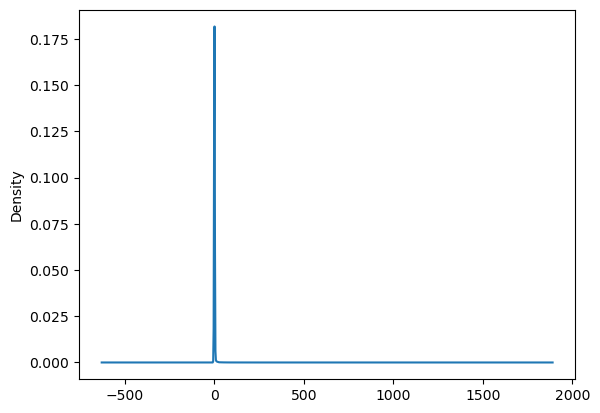

In [42]:
# Create a density plot to determine the distribution of the column values.
name_count.plot.density()

In [43]:
# Determine which values to replace if counts are less than ...?
replace_name = list(name_count[name_count<10].index)

# Replace in dataframe
for name in replace_name:
    application_df.NAME = application_df.NAME.replace(name,"Other")

In [44]:
application_df['NAME'].value_counts()

Other                                      21022
PARENT BOOSTER USA INC                      1260
TOPS CLUB INC                                765
UNITED STATES BOWLING CONGRESS INC           700
WASHINGTON STATE UNIVERSITY                  492
                                           ...  
CASCADE 4-H FOUNDATION                        10
FREE & ACCEPTED MASONS OF WASHINGTON          10
NEW MEXICO GARDEN CLUBS INC                   10
NATIONAL ASSOCIATION OF HISPANIC NURSES       10
UNION OF CALIFORNIA STATE WORKERS             10
Name: NAME, Length: 223, dtype: int64

In [45]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes=='object'].index.tolist()
application_df[application_cat].nunique()

NAME                223
APPLICATION_TYPE      9
AFFILIATION           6
CLASSIFICATION        6
USE_CASE              5
ORGANIZATION          4
INCOME_AMT            9
dtype: int64

In [46]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()

,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ART THERAPY ASSOCIATION INC,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True,right_index=True)
application_df = application_df.drop(columns=application_cat)
application_df.head()

,ASK_AMT,IS_SUCCESSFUL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values.reshape(-1, 1)
X = application_df.drop("IS_SUCCESSFUL", axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, stratify=y)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [49]:
# Input features
len(X_train_scaled[0])

263

In [50]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])   # 263
hidden_nodes_layer1 = 130                         # Between input=263 and not more than 2*input 
hidden_nodes_layer2 = 30                         # input=130 
hidden_nodes_layer3 = 10 

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,input_dim=number_input_features,activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3,activation='relu'))

# Output layer 
nn.add(tf.keras.layers.Dense(units=1,activation='sigmoid')) # binary classifier: sigmoid (1 output neuron with real value in [0,1])

# Check the structure of the model
nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 130)               34320     
                                                                 
 dense_23 (Dense)            (None, 30)                3930      
                                                                 
 dense_24 (Dense)            (None, 10)                310       
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 38,571
Trainable params: 38,571
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Compile the model
nn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.4731 - accuracy: 0.7699
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4447 - accuracy: 0.7816
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4417 - accuracy: 0.7839
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4398 - accuracy: 0.7862
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4385 - accuracy: 0.7869
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4372 - accuracy: 0.7877
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4365 - accuracy: 0.7873
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4357 - accuracy: 0.7883
Epoch 9/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4350 - accuracy: 0.7892
Epoch 10/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4345 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.4182 - accuracy: 0.7966
Epoch 82/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4177 - accuracy: 0.7975
Epoch 83/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4181 - accuracy: 0.7968
Epoch 84/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4181 - accuracy: 0.7970
Epoch 85/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4178 - accuracy: 0.7964
Epoch 86/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4176 - accuracy: 0.7968
Epoch 87/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4172 - accuracy: 0.7980
Epoch 88/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4179 - accuracy: 0.7966
Epoch 89/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4171 - accuracy: 0.7973
Epoch 90/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4183 - accuracy: 

In [52]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.4992 - accuracy: 0.7848 - 321ms/epoch - 1ms/step
Loss: 0.4991820752620697, Accuracy: 0.7848396301269531


In [53]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/Opt",exist_ok=True)
checkpoint_path = "checkpoints/Opt/weights.{epoch:02d}.hdf5"

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq="epoch",
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.4182 - accuracy: 0.7980
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4173 - accuracy: 0.7973
Epoch 3/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4164 - accuracy: 0.7974
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4167 - accuracy: 0.7984
Epoch 5/100
798/804 [============================>.] - ETA: 0s - loss: 0.4161 - accuracy: 0.7969
Epoch 5: saving model to checkpoints/Opt/weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.4164 - accuracy: 0.7965
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4167 - accuracy: 0.7977
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4167 - accuracy: 0.7975
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4159 - accuracy: 0.7979
Epoch 9/100
804/804 [=============================

804/804 [==============================] - 1s 1ms/step - loss: 0.4151 - accuracy: 0.7989
Epoch 64/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4147 - accuracy: 0.7980
Epoch 65/100
787/804 [============================>.] - ETA: 0s - loss: 0.4136 - accuracy: 0.7987
Epoch 65: saving model to checkpoints/Opt/weights.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.4141 - accuracy: 0.7984
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4147 - accuracy: 0.7981
Epoch 67/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4146 - accuracy: 0.7985
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4138 - accuracy: 0.7974
Epoch 69/100
804/804 [==============================] - 1s 1ms/step - loss: 0.4141 - accuracy: 0.7985
Epoch 70/100
770/804 [===========================>..] - ETA: 0s - loss: 0.4149 - accuracy: 0.7977
Epoch 70: saving model to checkpoints/Opt/weights.70.hdf5


In [54]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5243 - accuracy: 0.7832 - 335ms/epoch - 1ms/step
Loss: 0.5242859125137329, Accuracy: 0.7832069993019104


In [55]:
# Export our model to HDF5 file
nn.save('AlphabetSoupCharity_Optimization.h5')

### Running Random Forest Classifier on the dataset

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [57]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

In [58]:
# Fit the model
rf_model = rf_model.fit(X_train_scaled, np.ravel(y_train))

In [59]:
# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest model accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest model accuracy: 0.768
